# CNN model with CLAHE

This notebook also contains the hyperparameter tuning experiments for the CNN models

## Loading in

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models
from random import randint
import albumentations as A
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
!pip install --upgrade tensorflow

In [ ]:
#mount my drive

from google.colab import drive

drive.mount ('/content/drive')

Mounted at /content/drive


In [ ]:
#download the images
!unzip "/content/drive/My Drive/Thesis/images_by_AR.zip" -d "/content"


In [ ]:
#load in datasets

train = pd.read_csv('/content/drive/My Drive/Thesis/train_us.csv')
test_us = pd.read_csv('/content/drive/My Drive/Thesis/test_us.csv')
test_imb = pd.read_csv('/content/drive/My Drive/Thesis/test_imbalanced.csv')
val = pd.read_csv('/content/drive/My Drive/Thesis/val_us.csv')

print (len(train))
print (len(val))
print (len(test_us))
print (len(test_imb))

74650
11243
9399
24175


In [ ]:
#check for missing images
dir = '/content/images_by_AR/'
missing_images = [filename for filename in filenames if not os.path.exists(os.path.join(dir, filename))]
print(f"Missing images: {missing_images}")  


Missing images: []


## Dataset creation

In [ ]:
#set up the augmentation pipeline
def augment (img):
  """Have the image augmented with random augmentation"""

  augmentations = A.Compose(
      [A.HorizontalFlip (p = 0.5), #50% chance of augmentation
       A.VerticalFlip(p=0.5),
       A.Rotate (limit=(-90,90), interpolation=cv.INTER_CUBIC, border_mode=cv.BORDER_REFLECT, p=0.5)]
  )

  augmented = augmentations(image=img)['image'] #run it through the pipeline

  return augmented

In [ ]:

import tensorflow as tf
import pandas as pd
import cv2
import numpy as np
import time

dir = '/content/images_by_AR/'

# Function to load and process images

def load_and_process_image(filename, label):
    # Decode the filename from bytes to string
    filename = filename.decode('utf-8')
    filename = os.path.join(dir, filename)
    # Read the image
    img = cv2.imread(filename)
    if img is None:
        raise ValueError(f"Image at {filename} not found.") #to warn if images cannot be read

    # Convert image from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply CLAHE
    img = A.clahe(img, tile_grid_size=(8,8), clip_limit = 2.5)

    #augmentation
    img = augment(img)

    #normalization
    img = img.astype(np.float32) / 255.0


    return img, label

# Create a tf.data.Dataset from the CSV
filenames = train['filename'].values
labels = train['class'].values

# Convert filenames and labels to TensorFlow Tensors
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

# Map the loading and processing function
def map_func(filename, label):
    img, label = load_and_process_image(filename.numpy(), label.numpy()) #filename and label have to be in numpy format for the function to work
    return img, label

# Apply tf.py_function and explicitly set output shapes
dataset = dataset.map(
    lambda filename, label: tf.py_function(
        func=map_func, inp=[filename, label], Tout=[tf.float32, tf.int64]
    ),
    num_parallel_calls=tf.data.experimental.AUTOTUNE #multi preprocessing
)

def set_shapes(img, label):
    img.set_shape((224, 224, 3))  # Set the shape for the image
    label.set_shape(())  # Set the shape for the label (scalar)
    return img, label

dataset = dataset.map(set_shapes)

# Batch and prefetch the dataset for performance
dataset = dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE) #prefetch multiple batches

# Test the dataset
for images, labels in dataset.take(1):
    print ('batch fetched')


batch fetched


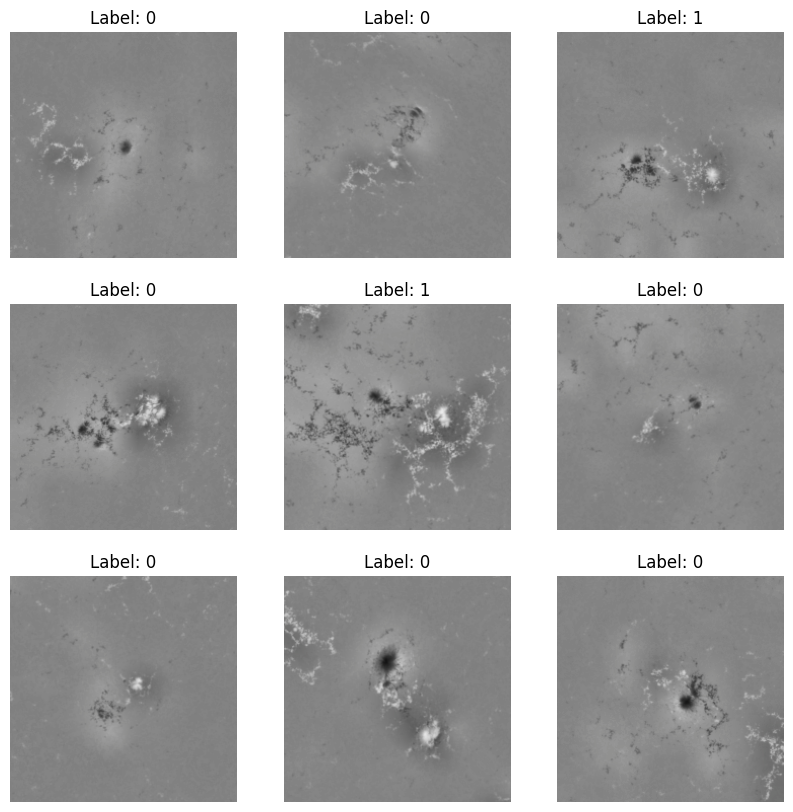

In [ ]:
import matplotlib.pyplot as plt

# Function to plot a grid of 9 images
def display_batch_of_images(images, labels):
    plt.figure(figsize=(10, 10))

    for i in range(9):  # Display the first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")  # Hide axes

    plt.show()

# Fetch one batch of images and labels
for images, labels in dataset.take(1):
    display_batch_of_images(images, labels)
    break


In [ ]:
import tensorflow as tf
import pandas as pd
import cv2
import numpy as np
import time

dir = '/content/images_by_AR/'

#loading in images and preprocess them
def load_and_process_image_val(filename, label):
    filename = filename.decode('utf-8')
    filename = os.path.join(dir, filename)
    #image loading
    img = cv2.imread(filename)
    if img is None:
        raise ValueError(f"Image at {filename} not found.")

    #convert to rgb
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #CLAHE
    img = A.clahe(img, tile_grid_size=(8,8), clip_limit = 2.5)

    #normalize the image to 0, 1
    img = img.astype(np.float32) / 255.0


    return img, label

#convert these filenames and labels to np arrays to pass to the map (), because the preprocessing functions need np arrays and not tensors
def map_func_val(filename, label):
    img, label = load_and_process_image_val(filename.numpy(), label.numpy())
    return img, label

#get the filenames and labels to use in the functions created above
filenames_val = val['filename'].values
labels_val = val['class'].values

#make the datasets (turns filenames and labels to tensors)
val_dataset = tf.data.Dataset.from_tensor_slices((filenames_val, labels_val))

def process_image_and_label_val(filename, label):
    #apply the function
    img, label = tf.py_function(func=map_func_val, inp=[filename, label], Tout=[tf.float32, tf.int64])

    #set this shape because they get lost in the tf.py_function and otherwise the model cannot read the shapes
    img.set_shape([224, 224, 3])
    label.set_shape([])

    return img, label

#map the function to the dataset so everything is processed
val_dataset = val_dataset.map(process_image_and_label_val)

val_dataset = val_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE) #batch size 32

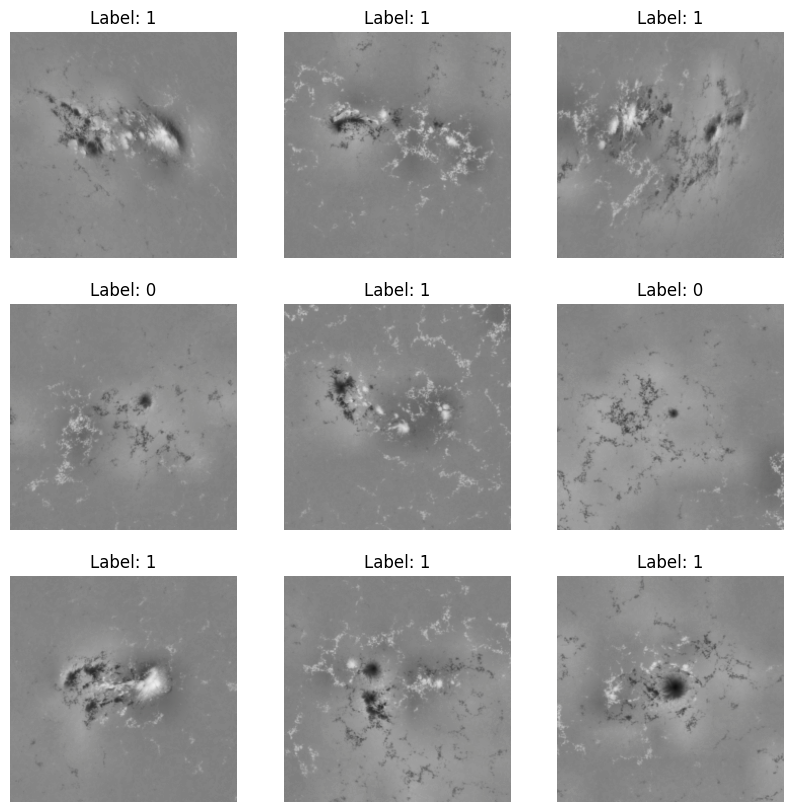

In [ ]:
for images, labels in val_dataset.take(1):
    display_batch_of_images(images, labels)
    break

In [ ]:
for img, label in val_dataset.take(1): #test the labels and shapes
    print(f"Validation batch shape: {img.shape}, Labels: {label.numpy()}")


Validation batch shape: (64, 224, 224, 3), Labels: [1 1 1 0 0 0 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0
 0 0 1 1 1 0 0 1 0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0]


## Final model

In [ ]:
recall = keras.metrics.Recall()
precision = keras.metrics.Precision()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, regularizers

#load model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#freeze
for layer in vgg16_model.layers:
    layer.trainable = False

#unfreeze last 2 (last convolutional layer)
for layer in vgg16_model.layers[-2:]:
    layer.trainable = True

#create model
inputs = layers.Input(shape=(224, 224, 3))
x = vgg16_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(0.0001))(x)  #add classification head

model = models.Model(inputs, outputs)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,715,201 (56.13 MB)

 Trainable params: 2,360,321 (9.00 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [ ]:
import keras

learning_rate_s = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.000001)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile (optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy', recall, precision])

history = model.fit (dataset, validation_data = val_dataset, epochs = 20,
                     callbacks=[
                        tf.keras.callbacks.EarlyStopping(patience=10),
                        tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Thesis/CNN_model_best_clahe.keras', save_best_only=True), #saving because google colab can sometimes time out
                        learning_rate_s],
                     verbose = 1, shuffle = True)

import pandas as pd
######################
# Save history to a DataFrame
history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/drive/My Drive/Thesis/training_history_CNN_clahe.csv', index=False)

Epoch 1/20
2333/2333 ━━━━━━━━━━━━━━━━━━━━ 909s 383ms/step - accuracy: 0.7348 - loss: 0.5262 - precision_2: 0.7509 - recall_2: 0.6958 - val_accuracy: 0.7849 - val_loss: 0.4713 - val_precision_2: 0.7968 - val_recall_2: 0.7650 - learning_rate: 1.0000e-04
Epoch 2/20
2333/2333 ━━━━━━━━━━━━━━━━━━━━ 859s 359ms/step - accuracy: 0.7725 - loss: 0.4775 - precision_2: 0.7900 - recall_2: 0.7383 - val_accuracy: 0.7885 - val_loss: 0.4668 - val_precision_2: 0.8098 - val_recall_2: 0.7542 - learning_rate: 1.0000e-04
Epoch 3/20
2333/2333 ━━━━━━━━━━━━━━━━━━━━ 861s 369ms/step - accuracy: 0.7763 - loss: 0.4712 - precision_2: 0.7917 - recall_2: 0.7460 - val_accuracy: 0.7892 - val_loss: 0.4627 - val_precision_2: 0.8113 - val_recall_2: 0.7538 - learning_rate: 1.0000e-04
Epoch 4/20
2333/2333 ━━━━━━━━━━━━━━━━━━━━ 881s 378ms/step - accuracy: 0.7796 - loss: 0.4664 - precision_2: 0.7930 - recall_2: 0.7529 - val_accuracy: 0.7856 - val_loss: 0.4647 - val_precision_2: 0.8128 - val_recall_2: 0.7421 - learning_rate: 1.0

Performance on the imbalanced dataset

In [ ]:
#test results

from keras.models import load_model

m = load_model ('/content/drive/My Drive/Thesis/CNN_model_best_clahe.keras')

y_pred_prob = m.predict (test_dataset)

756/756 ━━━━━━━━━━━━━━━━━━━━ 236s 294ms/step


In [ ]:
y_pred_im = (y_pred_prob > 0.5).astype(int)
y_pred_im = y_pred_im.reshape(len(test_imb),)
print (y_pred_im)

[0 0 0 ... 0 0 0]


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_true = test_imb['class'].values

accuracy = accuracy_score (y_true, y_pred_im)

print (accuracy)

cm = confusion_matrix(y_true, y_pred_im)

print (cm)

class_rep = classification_report (y_true, y_pred_im)

print (class_rep)

#TSS of 0.57

0.765377456049638
[[14650  4826]
 [  846  3853]]
              precision    recall  f1-score   support

           0       0.95      0.75      0.84     19476
           1       0.44      0.82      0.58      4699

    accuracy                           0.77     24175
   macro avg       0.69      0.79      0.71     24175
weighted avg       0.85      0.77      0.79     24175



Imbalanced test set

## Experiments

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy()

In [ ]:
recall = keras.metrics.Recall()
precision = keras.metrics.Precision()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, regularizers

#load model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#freeze
for layer in vgg16_model.layers:
    layer.trainable = False

#unfreeze last 2
for layer in vgg16_model.layers[-2:]:
    layer.trainable = True

#create model
inputs = layers.Input(shape=(224, 224, 3))
x = vgg16_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(0.0001))(x)  #add classification head

model = models.Model(inputs, outputs)

In [ ]:
#learning rate
import keras
learning_rate_s = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=10, min_lr=0.000001)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

model.compile (optimizer=optimizer, loss=loss, metrics=['accuracy', recall, precision])

In [ ]:
## model with learning rate 0.00001, 1 layers unfrozen and dropout 0.3, regularization 0.0001 and clahe clip limit = 2.5

In [ ]:
#learning rate = 0.00001, and 1 layer unfrozen in the vgg16 model
import keras
learning_rate_s = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=7, min_lr=0.000001)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

model.compile (optimizer=optimizer, loss=loss, metrics=['accuracy'])

history = model.fit (dataset, validation_data = val_dataset, epochs = 10,
                     callbacks=[
                        tf.keras.callbacks.EarlyStopping(patience=7),
                        learning_rate_s],
                     verbose = 1, shuffle = True)

import pandas as pd

# Save history to a DataFrame
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history_CNN_clahe.csv', index=False)

#improvements in model are minimal over the epochs, a higher learning rate could speed up the convergence

Epoch 1/10
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 643s 343ms/step - accuracy: 0.6699 - loss: 0.5981 - val_accuracy: 0.7494 - val_loss: 0.4939 - learning_rate: 1.0000e-05
Epoch 2/10
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 676s 341ms/step - accuracy: 0.7476 - loss: 0.5086 - val_accuracy: 0.7633 - val_loss: 0.4835 - learning_rate: 1.0000e-05
Epoch 3/10
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 686s 343ms/step - accuracy: 0.7586 - loss: 0.4960 - val_accuracy: 0.7705 - val_loss: 0.4786 - learning_rate: 1.0000e-05
Epoch 4/10
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 685s 344ms/step - accuracy: 0.7610 - loss: 0.4914 - val_accuracy: 0.7742 - val_loss: 0.4738 - learning_rate: 1.0000e-05
Epoch 5/10
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 673s 339ms/step - accuracy: 0.7647 - loss: 0.4861 - val_accuracy: 0.7761 - val_loss: 0.4722 - learning_rate: 1.0000e-05
Epoch 6/10
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 681s 339ms/step - accuracy: 0.7683 - loss: 0.4831 - val_accuracy: 0.7765 - val_loss: 0.4705 - learning_rate: 1.0000e-05
Epoch 7/10
 412/1867 ━━━━━━━

KeyboardInterrupt: 

## ResNet

Trying another transfer learning model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet101
from tensorflow.keras import layers, models, regularizers

#load model
res = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#freeze
for layer in res.layers:
    layer.trainable = False

#unfreeze last one (last two are not trainable so the trainable layer is in the last three)
for layer in res.layers[-3:]:
    layer.trainable = True

#create model
inputs = layers.Input(shape=(224, 224, 3))
x = res(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(0.0001))(x)  #add classification head

model = models.Model(inputs, outputs)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet101 (Functional)               │ (None, 7, 7, 2048)          │      42,658,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,660,225 (162.74 MB)

 Trainable params: 6,145 (24.00 KB)

 Non-trainable params: 42,654,080 (162.71 MB)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy()
recall = keras.metrics.Recall()
precision = keras.metrics.Precision()

In [ ]:
#learning rate
import keras

learning_rate_s = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=10, min_lr=0.000001)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

model.compile (optimizer=optimizer, loss=loss, metrics=['accuracy', recall, precision])

history = model.fit (dataset, validation_data = val_dataset, epochs = 20,
                     callbacks=[
                        tf.keras.callbacks.EarlyStopping(patience=15),
                        learning_rate_s,
                        tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Thesis/CNN_model_best_clahe.keras', save_best_only=True)
                    ], verbose = 1, shuffle = True)

import pandas as pd

# Save history to a DataFrame
history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/drive/My Drive/Thesis/training_history_CNN_clahe.csv', index=False)

#ResNet takes a longer time to truly converge, but seems to have larger updates earlier on, it does yield poorer results especially in terms of recall

Epoch 1/20
2333/2333 ━━━━━━━━━━━━━━━━━━━━ 982s 410ms/step - accuracy: 0.5140 - loss: 0.7138 - precision_1: 0.5102 - recall_1: 0.4811 - val_accuracy: 0.7357 - val_loss: 0.6537 - val_precision_1: 0.7419 - val_recall_1: 0.7229 - learning_rate: 1.0000e-05
Epoch 2/20
2333/2333 ━━━━━━━━━━━━━━━━━━━━ 912s 384ms/step - accuracy: 0.5816 - loss: 0.6720 - precision_1: 0.5764 - recall_1: 0.5949 - val_accuracy: 0.7402 - val_loss: 0.6212 - val_precision_1: 0.7757 - val_recall_1: 0.6759 - learning_rate: 1.0000e-05
Epoch 3/20
2333/2333 ━━━━━━━━━━━━━━━━━━━━ 938s 402ms/step - accuracy: 0.6374 - loss: 0.6388 - precision_1: 0.6365 - recall_1: 0.6299 - val_accuracy: 0.7358 - val_loss: 0.5974 - val_precision_1: 0.7794 - val_recall_1: 0.6580 - learning_rate: 1.0000e-05
Epoch 4/20
2333/2333 ━━━━━━━━━━━━━━━━━━━━ 943s 386ms/step - accuracy: 0.6733 - loss: 0.6151 - precision_1: 0.6827 - recall_1: 0.6394 - val_accuracy: 0.7360 - val_loss: 0.5800 - val_precision_1: 0.7784 - val_recall_1: 0.6599 - learning_rate: 1.0

KeyboardInterrupt: 

## The best model (experiment)

In [ ]:
recall = keras.metrics.Recall()
precision = keras.metrics.Precision()

In [ ]:
#learning rate = 0.0001, and 1 layer unfrozen in the vgg16 model, higher learning rate for faster convergence and regularizer to penalize large weights with a lower dropout
import keras
learning_rate_s = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=7, min_lr=0.000001)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile (optimizer=optimizer, loss=loss, metrics=['accuracy', recall, precision])

history = model.fit (dataset, validation_data = val_dataset, epochs = 10,
                     callbacks=[
                        tf.keras.callbacks.EarlyStopping(patience=7),
                        learning_rate_s],
                     verbose = 1, shuffle = True)

import pandas as pd

# Save history to a DataFrame
history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/drive/My Drive/Thesis/training_history_CNN_clahe.csv', index=False)

#this one converges faster into higher val accuracies than the one with lr = 0.00001

Epoch 1/10
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 640s 339ms/step - accuracy: 0.7217 - loss: 0.5390 - precision: 0.7571 - recall: 0.7110 - val_accuracy: 0.7765 - val_loss: 0.4710 - val_precision: 0.8019 - val_recall: 0.7345 - learning_rate: 1.0000e-04
Epoch 2/10
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 687s 344ms/step - accuracy: 0.7693 - loss: 0.4795 - precision: 0.7850 - recall: 0.7355 - val_accuracy: 0.7835 - val_loss: 0.4664 - val_precision: 0.8139 - val_recall: 0.7352 - learning_rate: 1.0000e-04
Epoch 3/10
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 671s 339ms/step - accuracy: 0.7740 - loss: 0.4731 - precision: 0.7882 - recall: 0.7435 - val_accuracy: 0.7839 - val_loss: 0.4646 - val_precision: 0.8117 - val_recall: 0.7392 - learning_rate: 1.0000e-04
Epoch 4/10
1867/1867 ━━━━━━━━━━━━━━━━━━━━ 617s 330ms/step - accuracy: 0.7748 - loss: 0.4695 - precision: 0.7879 - recall: 0.7462 - val_accuracy: 0.7815 - val_loss: 0.4665 - val_precision: 0.8137 - val_recall: 0.7303 - learning_rate: 1.0000e-04
Epoch 5/10
1867/1867 ━━━

In [ ]:
history_df.head()

,accuracy,loss,precision,recall,val_accuracy,val_loss,val_precision,val_recall,learning_rate
0,0.750419,0.505908,0.769661,0.721345,0.776518,0.471016,0.801894,0.734490,0.0001
1,0.768336,0.479693,0.784808,0.739417,0.783522,0.466387,0.813885,0.735157,0.0001
2,0.771752,0.474111,0.786884,0.745378,0.783856,0.464608,0.811722,0.739159,0.0001
3,0.773979,0.471502,0.788796,0.748326,0.781521,0.466538,0.813677,0.730265,0.0001
4,0.776239,0.468152,0.789919,0.752646,0.786413,0.462193,0.803344,0.758506,0.0001


In [ ]:
model.save ('/content/drive/My Drive/Thesis/model_subset.keras')

In [ ]:
def loss_accuracy_graph (history):

  train_accuracy = history.history['accuracy']
  train_loss = history.history ['loss']
  validation_accuracy = history.history['val_accuracy']
  validation_loss = history.history ['val_loss']

  fig, axes = plt.subplots (1,2, figsize = (15,5))

  axes[0].plot (train_accuracy, label = 'training')
  axes[0].plot (validation_accuracy, label = 'validation')
  axes[0].set_xlim (1, 10)
  axes[0].legend (loc = 'lower right')
  axes[0].grid (True)
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Accuracy')
  axes[0].set_title('Training and Validation Accuracy')

  axes[1].plot (train_loss, label = 'training')
  axes[1].plot (validation_loss, label = 'validation')
  axes[1].set_xlim (1, 10)
  axes[1].legend (loc = 'upper right')
  axes[1].grid (True)
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Loss')
  axes[1].set_title('Training and Validation Loss')

  plt.tight_layout()
  plt.show()


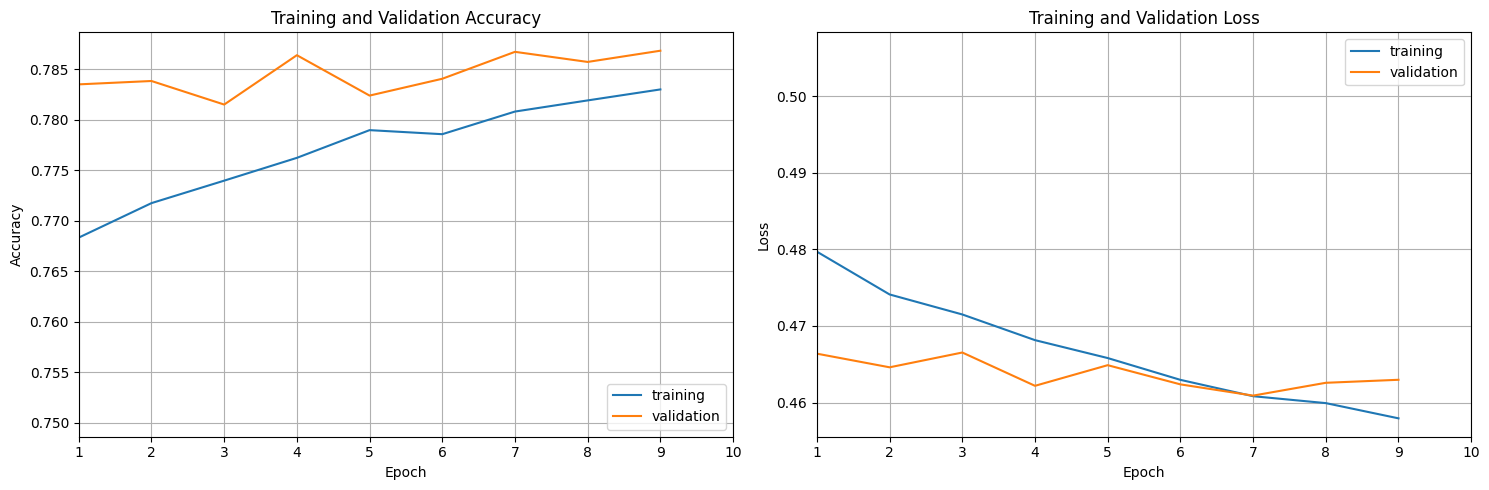

In [ ]:
import matplotlib.pyplot as plt

loss_accuracy_graph (history)

In [ ]:
print ('Mean validation accuracy: {}'.format(history_df['val_accuracy'].mean()))
print ('Standard deviation of validation accuracy: {}'.format(history_df['val_accuracy'].std()))

Mean validation accuracy: 0.7837669670581817
Standard deviation of validation accuracy: 0.003143832195941957


In [ ]:
y_true = test['class'].values
y_pred_prob = model.predict (test_dataset)

235/235 ━━━━━━━━━━━━━━━━━━━━ 65s 277ms/step


In [ ]:
#testing on a balanced test set

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


y_pred = (y_pred_prob > 0.5).astype(int)
y_pred = y_pred.reshape(7520,)
print (y_pred)


accuracy = accuracy_score (y_true, y_pred)

print (accuracy)

cm = confusion_matrix(y_true, y_pred)

print (cm)

class_rep = classification_report (y_true, y_pred)

print (class_rep)

#TSS = 0.5484
#TPR = 0.8104

#in line with other studies using transfer learning and in line with Boucheron et al. (2023)

[0 1 0 ... 0 0 1]
0.7752659574468085
[[2778  982]
 [ 708 3052]]
              precision    recall  f1-score   support

           0       0.80      0.74      0.77      3760
           1       0.76      0.81      0.78      3760

    accuracy                           0.78      7520
   macro avg       0.78      0.78      0.77      7520
weighted avg       0.78      0.78      0.77      7520



In [ ]:
#test on unbalanced test set
import keras
from keras.models import load_model

model_im = load_model ('/content/drive/My Drive/Thesis/model_subset.keras')

y_pred_prob_im = model_im.predict (test_dataset)



152/152 ━━━━━━━━━━━━━━━━━━━━ 63s 318ms/step


ValueError: cannot reshape array of size 4835 into shape (7520,)

In [ ]:
y_pred_im = (y_pred_prob_im > 0.5).astype(int)
y_pred_im = y_pred_im.reshape(len(test),)
print (y_pred_im)

[1 0 0 ... 0 0 0]


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_true = test['class'].values

accuracy = accuracy_score (y_true, y_pred_im)

print (accuracy)

cm = confusion_matrix(y_true, y_pred_im)

print (cm)

class_rep = classification_report (y_true, y_pred_im)

print (class_rep)


#apart from a low precision score, the model performs relatively well on the imbalanced test data, the precision might get better with more examples of the positive class

0.7598759048603929
[[2883 1012]
 [ 149  791]]
              precision    recall  f1-score   support

           0       0.95      0.74      0.83      3895
           1       0.44      0.84      0.58       940

    accuracy                           0.76      4835
   macro avg       0.69      0.79      0.70      4835
weighted avg       0.85      0.76      0.78      4835



In [ ]:
#this model will be trained on the entire dataset for 20 epochs with an initial learning rate of 0.0001

## Another layer unfrozen and low learning rate

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, regularizers

#load model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#freeze
for layer in vgg16_model.layers:
    layer.trainable = False

#unfreeze last 2
for layer in vgg16_model.layers[-3:]:
    layer.trainable = True

#create model
inputs = layers.Input(shape=(224, 224, 3))
x = vgg16_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(0.0001))(x)  #add classification head

model = models.Model(inputs, outputs)

model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,715,201 (56.13 MB)

 Trainable params: 4,720,129 (18.01 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [ ]:
import keras

learning_rate_s = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.000001)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

model.compile (optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy', recall, precision])

history = model.fit (dataset, validation_data = val_dataset, epochs = 20,
                     callbacks=[
                        tf.keras.callbacks.EarlyStopping(patience=10),
                        tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Thesis/CNN_model_best_clahe_2.keras', save_best_only=True), #saving because google colab can sometimes time out
                        learning_rate_s],
                     verbose = 1, shuffle = True)

import pandas as pd
#################################
# Save history to a DataFrame
history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/drive/My Drive/Thesis/training_history_CNN_clahe_2.csv', index=False)

#no major improvement, same accuracy and loss values

Epoch 1/20
2333/2333 ━━━━━━━━━━━━━━━━━━━━ 1015s 431ms/step - accuracy: 0.7267 - loss: 0.5347 - precision_2: 0.7676 - recall_2: 0.7176 - val_accuracy: 0.7767 - val_loss: 0.4740 - val_precision_2: 0.8172 - val_recall_2: 0.7131 - learning_rate: 1.0000e-05
Epoch 2/20
2333/2333 ━━━━━━━━━━━━━━━━━━━━ 1028s 428ms/step - accuracy: 0.7762 - loss: 0.4715 - precision_2: 0.7921 - recall_2: 0.7451 - val_accuracy: 0.7862 - val_loss: 0.4674 - val_precision_2: 0.8147 - val_recall_2: 0.7408 - learning_rate: 1.0000e-05
Epoch 3/20
2333/2333 ━━━━━━━━━━━━━━━━━━━━ 992s 407ms/step - accuracy: 0.7810 - loss: 0.4631 - precision_2: 0.7961 - recall_2: 0.7517 - val_accuracy: 0.7856 - val_loss: 0.4681 - val_precision_2: 0.8171 - val_recall_2: 0.7360 - learning_rate: 1.0000e-05
Epoch 4/20
2333/2333 ━━━━━━━━━━━━━━━━━━━━ 996s 413ms/step - accuracy: 0.7817 - loss: 0.4587 - precision_2: 0.7947 - recall_2: 0.7559 - val_accuracy: 0.7829 - val_loss: 0.4692 - val_precision_2: 0.8170 - val_recall_2: 0.7291 - learning_rate: 1

## On undersampled training set (entire set) and imbalanced validation set

Experiments with larger datasets (undersampled training set/entire dataset) cost a lot of computational power and showed signs of overfitting. Many were removed from this notebook, since these are not the final datasets.

In [ ]:
## model with extra dense layer, dropout of 0.4 and all layers frozen, lr = 0.0001

history = model.fit (dataset, validation_data = val_dataset, epochs = 10,
                     callbacks=[
                        tf.keras.callbacks.EarlyStopping(patience=5),
                        learning_rate_s,
                        tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Thesis/CNN_model_best_clahe_2.keras', save_best_only=True)
                    ], verbose = 1, shuffle = True)

import pandas as pd

# Save history to a DataFrame
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history_CNN_clahe.csv', index=False)

#loss not improving? Accuracy not improving?
#val accuracy high due to it being imbalanced

Epoch 1/10
9332/9332 ━━━━━━━━━━━━━━━━━━━━ 3329s 356ms/step - accuracy: 0.6973 - loss: 0.5699 - val_accuracy: 0.8028 - val_loss: 0.4683 - learning_rate: 1.0000e-04
Epoch 2/10
9332/9332 ━━━━━━━━━━━━━━━━━━━━ 3321s 350ms/step - accuracy: 0.7502 - loss: 0.5078 - val_accuracy: 0.8004 - val_loss: 0.4799 - learning_rate: 1.0000e-04
Epoch 3/10
9332/9332 ━━━━━━━━━━━━━━━━━━━━ 3301s 348ms/step - accuracy: 0.7567 - loss: 0.4988 - val_accuracy: 0.8002 - val_loss: 0.4891 - learning_rate: 1.0000e-04
Epoch 4/10
  88/9332 ━━━━━━━━━━━━━━━━━━━━ 44:05 286ms/step - accuracy: 0.7783 - loss: 0.4717

KeyboardInterrupt: 